In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import random
import os
from scipy.spatial.distance import cityblock

In [8]:
class Environment:
    def __init__(self, maze_file):
        self.maze = np.load(maze_file)
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up
        self.start_state = (0, self.maze.shape[1] - 1)
        self.goal_state = (self.maze.shape[0] - 1, 0)
    
    def is_valid_move(self, x, y):
        return 0 <= x < self.maze.shape[0] and 0 <= y < self.maze.shape[1] and self.maze[x, y] == 0
    
    def get_next_state(self, x, y, action):
        dx, dy = self.actions[action]
        next_x, next_y = x + dx, y + dy
        if self.is_valid_move(next_x, next_y):
            return next_x, next_y
        return x, y
    
    def draw(self, filename):
        plt.figure()
        im = plt.imshow(self.maze, interpolation='none', aspect='equal', cmap='Greys')
        ax = plt.gca()

        plt.xticks([], [])
        plt.yticks([], [])

        ax.plot(self.goal_state[1], self.goal_state[0],
                'bs', markersize = 4)
        ax.plot(self.start_state[1], self.start_state[0],
                'rs', markersize = 4)
        # plt.savefig(filename, dpi = 300, bbox_inches = 'tight')
        plt.show()

In [13]:
class Agent:
    def __init__(self, environment, alpha=0.1, gamma=0.9, epsilon=0.1, num_episodes=5000):
        self.env = environment
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_episodes = num_episodes
        self.q_table = np.zeros((*self.env.maze.shape, len(self.env.actions)))
    
    def train(self, frame_interval=100, gif_name="policy_evolution.gif"):
        frame_filenames = []

        for episode in range(self.num_episodes):
            state = self.env.start_state
            episode_reward = 0
            while state != self.env.goal_state:
                x, y = state
                if random.uniform(0, 1) < self.epsilon:
                    action = random.randint(0, len(self.env.actions) - 1)  # Explore
                else:
                    action = np.argmax(self.q_table[x, y])  # Exploit
                next_x, next_y = self.env.get_next_state(x, y, action)

                if (next_x, next_y) == self.env.goal_state:
                    reward = 1
                elif (next_x, next_y) == (x, y):
                    reward = -0.2  # High penalty for hitting a wall
                else:
                    reward = -0.01  # Small penalty for valid move

                max_next_q = np.max(self.q_table[next_x, next_y])
                self.q_table[x, y, action] += self.alpha * (
                    reward + self.gamma * max_next_q - self.q_table[x, y, action]
                )

                state = (next_x, next_y)
                episode_reward += reward
            
            if episode % frame_interval == 0:
                filename = f"temp_policy_frame_{episode}.png"
                self._save_policy_frame(episode, filename)
                frame_filenames.append(filename)

            if episode % 1000 == 0:
                print(f"Episode {episode}, Epsilon: {self.epsilon:.3f}, Reward: {episode_reward}")

        self._create_policy_gif(frame_filenames, gif_name)
        
        # Cleanup temporary files
        for filename in frame_filenames:
            os.remove(filename)
    
    def generate_solution_gif(self, output_filename="solution_path.gif"):
        frames = []
        state = self.env.start_state
        solution_path = [state]
        while state != self.env.goal_state:
            x, y = state
            action = np.argmax(self.q_table[x, y])
            next_x, next_y = self.env.get_next_state(x, y, action)
            solution_path.append((next_x, next_y))
            state = (next_x, next_y)
            frame = np.copy(self.env.maze)
            for sx, sy in solution_path:
                frame[sx, sy] = 0.5  # Path is shown in gray
            frame[x, y] = 0.8  # Agent is shown in red
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(frame, cmap="gray")
            ax.scatter(y, x, c="red", s=100)  # Highlight agent with a red dot
            ax.axis("off")
            plt.tight_layout()
            
            # Save frame to buffer
            buf = f"frame_{len(frames)}.png"
            plt.savefig(buf, dpi=100, bbox_inches='tight')
            frames.append(imageio.imread(buf))
            plt.close()
            os.remove(buf)  # Remove the intermediate PNG file
        
        # Ensure the last frame is included
        x, y = solution_path[-1]
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(self.env.maze, cmap="gray")
        for sx, sy in solution_path:
            ax.scatter(sy, sx, c="gray", s=50)
        ax.scatter(y, x, c="red", s=100)  # Final position in red
        ax.axis("off")
        plt.tight_layout()
        buf = "final_frame.png"
        plt.savefig(buf, dpi=100, bbox_inches='tight')
        frames.append(imageio.imread(buf))
        plt.close()
        os.remove(buf)  # Remove the final PNG file
        
        # Save the GIF
        imageio.mimsave(output_filename, frames, fps=5)
        print(f"Q-learning completed. GIF saved as '{output_filename}'.")

    def show_policy(self):
        policy_arrows = {
            0: "\u2192",  # Right arrow
            1: "\u2193",  # Down arrow
            2: "\u2190",  # Left arrow
            3: "\u2191"   # Up arrow
        }

        maze_with_policy = np.copy(self.env.maze)
        fig, ax = plt.subplots(figsize=(5, 5))

        for i in range(maze_with_policy.shape[0]):
            for j in range(maze_with_policy.shape[1]):
                if maze_with_policy[i, j] == 0:  # Open cell
                    if (i, j) == (maze_with_policy.shape[0] - 1, 0):  # Bottom-left corner
                        ax.plot(j, i,'bs', markersize = 4)
                    else:
                        best_action = np.argmax(self.q_table[i, j])
                        arrow = policy_arrows[best_action]
                        ax.text(j, i, arrow, ha='center', va='center', color='black', fontsize=12)
        ax = plt.gca()
        ax.imshow(maze_with_policy, "Greys")
        plt.xticks([], [])
        plt.yticks([], [])
        
        plt.show()

    def _save_policy_frame(self, episode, filename):
        # Reuse the visualization logic from show_policy() but save to file
        policy_arrows = {
            0: "\u2192", 1: "\u2193", 2: "\u2190", 3: "\u2191"
        }
        maze = np.copy(self.env.maze)
        fig, ax = plt.subplots(figsize=(5, 5))
        
        for i in range(maze.shape[0]):
            for j in range(maze.shape[1]):
                if maze[i, j] == 0:  # Open cell
                    best_action = np.argmax(self.q_table[i, j])
                    arrow = policy_arrows[best_action]
                    ax.text(j, i, arrow, ha='center', va='center', color='black', fontsize=12)
        
        ax.imshow(maze, "Greys")
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title(f"Episode: {episode}")
        plt.savefig(filename, bbox_inches='tight', dpi=100)
        plt.close()

    def _create_policy_gif(self, frame_files, output_filename, fps=2):
        # Compile frames into a GIF
        frames = [imageio.imread(filename) for filename in frame_files]
        imageio.mimsave(output_filename, frames, fps=fps)
        print(f"Policy evolution GIF saved as '{output_filename}'.")


Episode 0, Epsilon: 0.100, Reward: -71.19000000000032
Episode 1000, Epsilon: 0.100, Reward: 0.1899999999999996
Episode 2000, Epsilon: 0.100, Reward: 0.4099999999999997
Episode 3000, Epsilon: 0.100, Reward: 0.009999999999999565
Episode 4000, Epsilon: 0.100, Reward: 0.1699999999999996
Policy evolution GIF saved as 'policy_evolution_20.gif'.
Q-learning completed. GIF saved as 'solution_path_20.gif'.


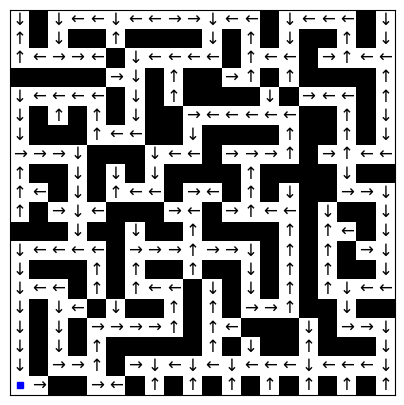

In [14]:
env = Environment("maze_20.npy")
agent = Agent(env)
agent.train(frame_interval=100, gif_name="policy_evolution_20.gif")
agent.generate_solution_gif(output_filename="solution_path_20.gif")
agent.show_policy()

Episode 0, Epsilon: 0.100, Reward: -7183.2100000357095
Episode 100, Epsilon: 0.100, Reward: -1708.4699999993784
Episode 200, Epsilon: 0.100, Reward: -334.6099999999103
Episode 300, Epsilon: 0.100, Reward: -406.26999999987817
Policy evolution GIF saved as 'policy_evolution_100.gif'.


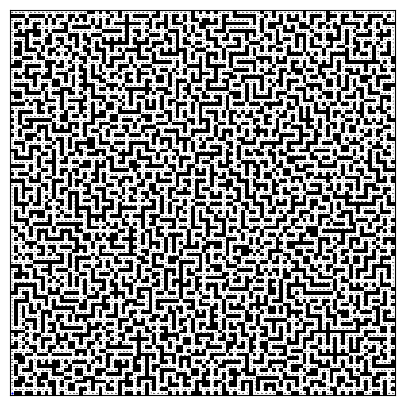

In [7]:
env = Environment("maze_100.npy")
agent = Agent(env, alpha=0.1, gamma=0.9, epsilon=0.1, num_episodes=400)
agent.train(frame_interval=100, gif_name="policy_evolution_100.gif")
# agent.generate_solution_gif(output_filename="solution_path_100.gif")
agent.show_policy()

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def draw_vintage_maze(maze, start, goal, scale=10, filename="vintage_maze.png"):
    # Define vintage colors
    bg_color = (204, 102, 51)  # Warm orange background
    wall_color = (102, 51, 0)  # Dark brown walls
    start_color = (255, 255, 255)  # White for start
    goal_color = (0, 0, 0)  # Black for goal

    # Increase the resolution
    height, width = maze.shape
    img_height, img_width = height * scale, width * scale
    maze_colored = np.full((img_height, img_width, 3), bg_color, dtype=np.uint8)  # Background fill

    # Draw thick, smooth walls
    for i in range(height):
        for j in range(width):
            if maze[i, j] < 128:  # Wall detection
                cv2.rectangle(
                    maze_colored, 
                    (j * scale, i * scale), 
                    ((j + 1) * scale, (i + 1) * scale), 
                    wall_color, 
                    -1, 
                    cv2.LINE_AA
                )

    # Scale start and goal positions
    start_scaled = (start[1] * scale + scale // 2, start[0] * scale + scale // 2)
    goal_scaled = (goal[1] * scale + scale // 2, goal[0] * scale + scale // 2)

    # Draw start and goal markers with proper size
    cv2.circle(maze_colored, start_scaled, scale // 2, start_color, -1, cv2.LINE_AA)
    cv2.circle(maze_colored, goal_scaled, scale // 2, goal_color, -1, cv2.LINE_AA)

    # Save and display the styled maze
    cv2.imwrite(filename, maze_colored)

    # Show the image using PIL for better visualization
    from PIL import Image
    import IPython.display as display
    display.display(Image.open(filename))


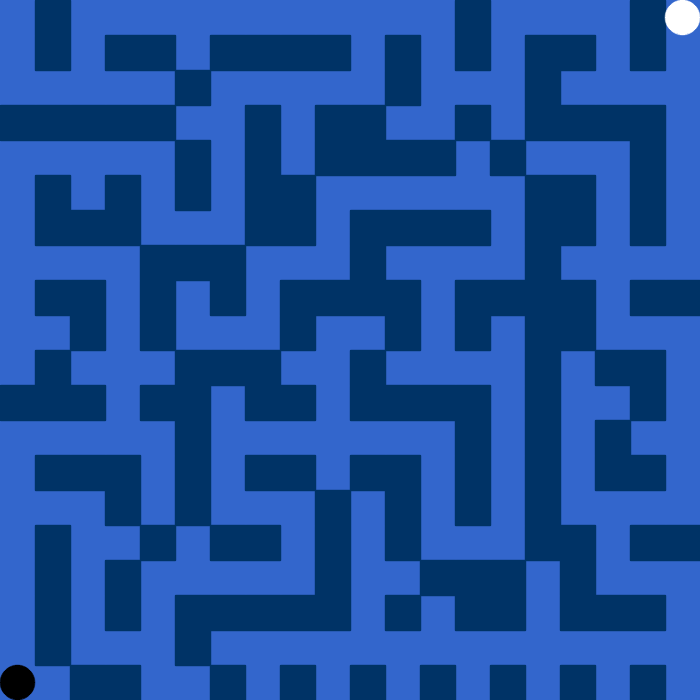

In [68]:
# Convert maze from 0s and 1s to 0.3 (dark walls) and 0.7 (light paths)
maze = env.maze.astype(float)
maze[maze == 0] = 255  # Darker for walls
maze[maze == 1] = 0  # Lighter for paths
maze = maze.astype(np.uint8)

# Call the function with the updated maze
draw_vintage_maze(maze, start=env.start_state, goal=env.goal_state, scale=35)
